# Programming Exercise 8: Anomaly detection

Welcome to part 1 of programming exercise 8, anomaly dedection. In this exercise, we will implement the anomaly detection algorithm and apply it to detect failing servers on a network. 

**Instruction:**
- To run code, click on a corresponding cell and press `Shift+Enter` keys simultaneously or `Click Cell -> Run Cell`.

**Objective:**
- To learn how to implement the anomaly detetction algorithm to detect anomalies in the dataset.

**You will learn how to:**
- implement the anomaly detetction algorithm to detect anomalies in the dataset.

## Problem overview ##

In this exercise, we shall be implementing an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. Imagine, while our servers were operating, we collected ${m = 307}$ examples of how they were behaving, and thus have an unlabeled dataset {$x^{(1)}, ..., x^{(m)}$}. 

Lets say we suspect that the vast majority of these examples are \normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

We will use a Gaussian model to detect anomalous examples in our dataset. We will first start on a 2D dataset that will allow us to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

## Import packages ##

First lets run the cell below to import all the packages that you will need for this exercise.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python
- [Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) is a common python library here being used to load `.mat` files in Python.
- [matplotlib](http://matplotlib.org) is a common library to plot graphs in python.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import scipy.io as sio

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# To suppress warnings
import warnings
warnings.filterwarnings('ignore')


%load_ext autoreload
%autoreload 2

### 1.1 - Load and visualize dataset points ###

As per tradition, we first load our data set `./data/ex8data1.mat`.

In [2]:
df_path = 'data/ex8data1.mat' 
data    = sio.loadmat(df_path)
X = data['X']
Xval = data['Xval']
yval = data['yval']

Now we can implement a function to plot the dataset points, `plot_data_points()`.

In [3]:
def plot_data_points(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], alpha=0.6, label='Dataset points')
    plt.grid(False)
    plt.tight_layout()
    plt.xlabel("Latency (ms)", fontsize=14)
    plt.ylabel("Throughput (mb/s)", fontsize=14)
    plt.axis([0.0, 30.0, 0.0, 30.0])
    plt.legend()
    plt.grid(True)

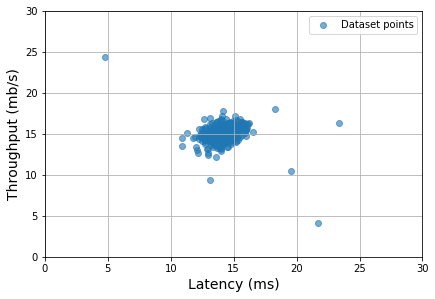

In [4]:
plot_data_points(X, y=None) #calling the function to plot the dataset

### 1.2 - Gaussian distribution ###

To perform anomaly detection, we will first need to fit a model to the data's distribution.

Given a training set {$x^{(1)}, ..., x^{(m)}$} ($x^{(i)} \in \mathcal{R}^n$), we want to estimate the Gaussian distribution for each of the features $x_{i}$. For each feature ${i = 1...n}$, wn need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the i-th dimension {$x_i^{(1)}, ..., x_i^{(m)}$} (the i-th dimension of each example).

The Gaussian distribution is given by:

![gaussian](images/gaussian_f.png)

### 1.3 - Estimating parameters for a Gaussian ###

**1.3.1 - Mean and variance**

We can estimate the parameters, $(\mu_i,\sigma_i^2)$, of the ${i-th}$ feature by using the following equations.

To estimate the `mean`, you will use:
![mean](images/mean.png)
and for the `variance` you will use:
![variance](images/variance.png)

In [5]:
def estimateGaussian(X):
    mu = np.mean(X, axis= 0)
    sigma_sqrd = np.var(X, axis= 0)
    return mu, sigma_sqrd

**1.3.2 - multivariate normal (or Gaussian) distribution**

The multivariate normal (or Gaussian) distribution with mean $\mu$ and covariance matrix $\Sigma$ is given by:

![multivariate_gaussian](images/multivariate_gaussian.png)

In [6]:
def multivariateGaussian(X, mu, sigma_sqrd):
    n = X.shape[1]
    if n > 1:                                          # Check if its multivariate or univariate
        sigma_sqrd = np.diag(sigma_sqrd)
    
    sigma_sqrd_det = np.linalg.det(sigma_sqrd)         # computing the determinant of sigma_sqrd
    sigma_sqrd_inv = np.linalg.pinv(sigma_sqrd)        # computing the inverse of the cov-matrix
    
    X_diff = X - mu
    eqn_part1 = 1/((2*np.pi)**(n/2.0) * sigma_sqrd_det**(0.5))
    eqn_part2 = np.exp(-0.5 * (X_diff.dot(sigma_sqrd_inv) * X_diff).sum(axis=1))
    return eqn_part1 * eqn_part2

**1.3.3 - Visualizing the contours of the fitted Gaussian distribution**

Our the next part, will be to visualize the contours of the fitted Gaussian distribution by implementing a function `visualizeFit()`. 

In [7]:
def visualizeFit(X,mu, sigma_sqrd):
    linespace = np.arange(0, 35.5, 0.5)
    xx, yy = np.meshgrid(linespace, linespace)
    Z = multivariateGaussian(np.c_[xx.ravel(), yy.ravel()],mu,sigma_sqrd);
    Z = Z.reshape(xx.shape)
    if np.sum(np.isinf(Z)) == 0:
        plt.contourf(xx, yy, Z, norm=LogNorm(vmin=Z.min(), 
                                             vmax=Z.max()),
                     levels=10.0 ** np.arange(-20, 0, 3))
        plt.contour(xx, yy, Z,  norm=LogNorm(vmin=Z.min(), 
                                             vmax=Z.max()),
                    levels=10.0 ** np.arange(-20, 0, 3),linewidths=1, colors='k')
    plot_data_points(X) # calling the function to plot the data points

**1.3.4 - Computing the $\mu$, $\sigma^2$ and running the multivariateGaussian()**

In [8]:
# Estimate mu and sigma
mu, sigma_sqrd = estimateGaussian(X);
#  Returns the density of the multivariate normal at each data point (row) of X
p = multivariateGaussian(X, mu, sigma_sqrd);

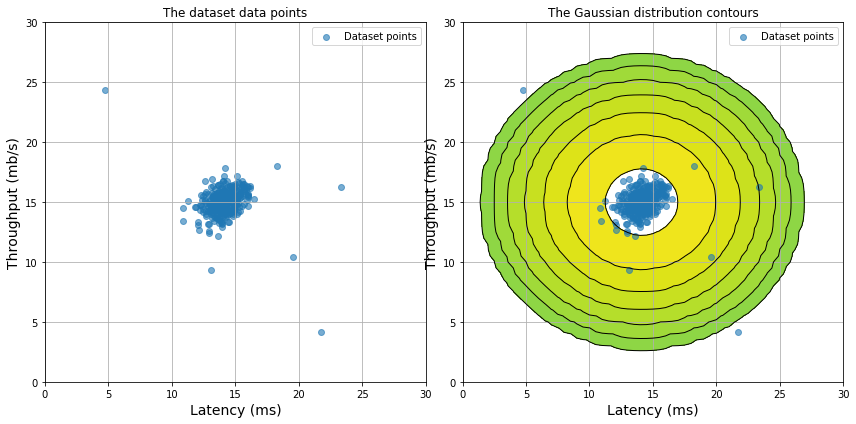

In [9]:
plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(1, 2, 1)
plot_data_points(X)
plt.title('The dataset data points')

plt.subplot(1, 2, 2)
visualizeFit(X,mu, sigma_sqrd)
plt.title("The Gaussian distribution contours")
plt.show()

From your plot, we can see that most of the examples are in the region with the highest probability (in layers), while the anomalous examples are in the regions with lower probabilities (out layers).

### 1.4 - Selecting the threshold, $\epsilon$

Now that we have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation
set.

In this part of the exercise, we will implement an algorithm to select the threshold, $\epsilon$ using the $F_1$ score on a cross validation set.

Therefore, we implement a function `selectThreshold()` that should return two values; the first is the selected threshold ". If an example $x$ has a low probability p(x) < $\epsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells us how well we are doing on fnding the ground truth anomalies given a certain threshold. 

For many different values of $\epsilon$, we will compute the resulting $F_1$ score by computing how many examples the current
threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision (prec) and recall (rec):
![fi](images/f1.png)

We compute precision and recall by:

![precision](images/prec_rec.png)

- ${tp}$ is the number of true positives: the ground truth label says it's an anomaly and our algorithm correctly classified it as an anomaly.

- ${fp}$ is the number of false positives: the ground truth label says it's not an anomaly, but our algorithm incorrectly classified it as an anomaly.

- ${fn}$ is the number of false negatives: the ground truth label says it's an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In [10]:
def selectThreshold(yval, pval):
    bestEpsilon = 0.0;
    bestF1 = 0.0;
    F1 = 0.0;
    stepsize = (np.max(pval) - np.min(pval)) / 1000
    for epsilon in np.arange(min(pval), max(pval), stepsize):
        cvPredictions = (pval < epsilon).astype(int).reshape(-1,1) # turn the vector of booleans to int
        fp = cvPredictions[np.nonzero(yval == 0)].sum()       # Prediction is True and yval is False
        tp = cvPredictions[np.nonzero(yval == 1)].sum()       # Prediction is True and yval = True
        fn = yval[np.nonzero(cvPredictions == 0)].sum()       # Yval is True and prediction is false
        
        precision = (tp /(tp + fp));                                # Precision
        recall = (tp/(tp+fn));                                      # Computes the recall
        F1= (2.0 * precision*recall) / (precision + recall);        # Computes the F1 score
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon,bestF1

In [11]:
pval = multivariateGaussian(Xval, mu, sigma_sqrd);
epsilon, F1 = selectThreshold(yval, pval)
print('\nBest epsilon found using cross-validation: ' + str(epsilon));
print('Best F1 on Cross Validation Set: %f.' % (F1));
# Find the outliers in the training set and plot the
outliers = np.where(p < epsilon);
print('With computed epsilon %f, the # of outliers found is %d.'%(epsilon,(p < epsilon).sum()))


Best epsilon found using cross-validation: 8.990852779269496e-05
Best F1 on Cross Validation Set: 0.875000.
With computed epsilon 0.000090, the # of outliers found is 6.


### 1.5 - Visualize Outliers ###

Next we implement a function `plotOutliers()` to plot the outliers.

In [12]:
def plotOutliers(X,outliers,mu,sigma_sqrd):
    visualizeFit(X,mu, sigma_sqrd)
    radius = (X.max() - X) / (X.max() - X.min())
    plt.scatter(X[outliers, 0], X[outliers, 1],
                facecolors='none', 
                edgecolors='r', s=1000 * radius, label="Outlier points")
    legend = plt.legend(loc='upper right')
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]

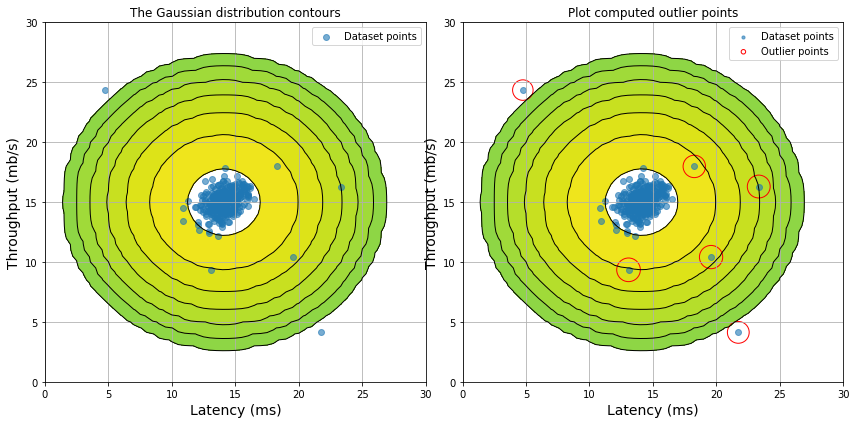

In [13]:
plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(1, 2, 1)
visualizeFit(X,mu, sigma_sqrd)
plt.title("The Gaussian distribution contours")

plt.subplot(1, 2, 2)
plotOutliers(X,outliers,mu,sigma_sqrd)
plt.title('Plot computed outlier points')
plt.show()

### 1.6 - High dimensional dataset ###

In this part of the exercise, we will run the anomaly detection algorithm we implemented on a more realistic and much harder dataset, `data/ex8data2.mat`. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

In [14]:
df_path = 'data/ex8data2.mat' 
data    = sio.loadmat(df_path)
X_train = data['X']
X_val = data['Xval']
y_val = data['yval']

Run the anomaly detection algorithm on the loaded multi-dimension dataset.

In [15]:
mu,sigma = estimateGaussian(X_train); #  Apply the same steps to the larger dataset 
pval     = multivariateGaussian(X_val, mu, sigma); #  Cross-validation set
epsilon,F1 = selectThreshold(y_val, pval); #  Find the best threshold

In [16]:
print('Best epsilon found using cross-validation:\n\t', epsilon);
print('Best F1 on Cross Validation Set:\n\t', F1);
print('# Outliers found:\n\t', (p < epsilon).sum());

Best epsilon found using cross-validation:
	 1.377228890761358e-18
Best F1 on Cross Validation Set:
	 0.6153846153846154
# Outliers found:
	 2


# **Novelty and Outlier Detection in Scikit-learn (Optional Material) #

Many applications require being able to decide whether a new observation belongs to the same distribution as existing observations (it is an inlier), or should be considered as different (it is an outlier). Often, this ability is used to clean real data sets. Two important distinctions must be made:

- **Outlier detection:** The training data contains outliers which are defined as observations that are far from the others. Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations
- **Novelty detection:** The training data is not polluted by outliers and we are interested in detecting whether a new observation is an outlier. In this context an outlier is also called a novelty.

Outlier detection and novelty detection are both used for anomaly detection, where one is interested in detecting abnormal or unusual observations. Outlier detection is then also known as unsupervised anomaly detection and novelty detection as semi-supervised anomaly detection. In the context of outlier detection, the outliers/anomalies cannot form a dense cluster as available estimators assume that the outliers/anomalies are located in low density regions. On the contrary, in the context of novelty detection, novelties/anomalies can form a dense cluster as long as they are in a low density region of the training data, considered as normal in this context.

The scikit-learn project provides a set of machine learning tools that can be used both for novelty or outlier detection. This strategy is implemented with objects learning in an unsupervised way from the data:

`estimator.fit(X_train)`
new observations can then be sorted as inliers or outliers with a predict method:
`estimator.predict(X_test)`

Inliers are labeled 1, while outliers are labeled -1. The predict method makes use of a threshold on the raw scoring function computed by the estimator. This scoring function is accessible through the `score_samples` method, while the threshold can be controlled by the `contamination` parameter.

The decision_function method is also defined from the scoring function, in such a way that negative values are outliers and non-negative ones are inliers:
`estimator.decision_function(X_test)`

Examples of the estimators in scikit-learn include: 
- [IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)
- [LocalOutlierFactor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)
- [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM)
- [EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope)

## Comparing performance of anomaliy detection algorithms ##

Comparing anomaly detection algorithms for outlier detection on sample dataset `./data/ex8data1.mat` for a comparison of the `svm.OneClassSVM`, the `ensemble.IsolationForest`, the `neighbors.LocalOutlierFactor` and `covariance.EllipticEnvelope`.

In [17]:
# sklearn outliers detection algorithms
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import time 

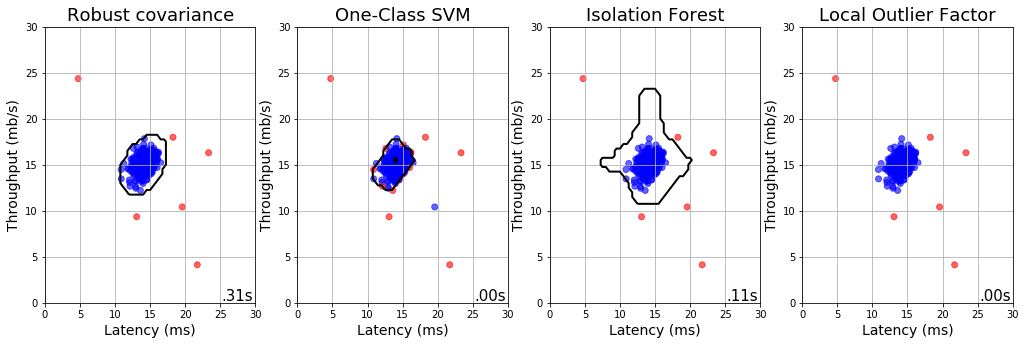

In [18]:
# import and load datasets
df_path = 'data/ex8data1.mat' 
data    = sio.loadmat(df_path)
X_train = data['X']
datasets = [X_train]

# Example settings
n_samples = len(X_train)
n_outliers = 6         # The result from ru nning the 
outliers_fraction = n_outliers/n_samples
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.5)),
    ("Isolation Forest", IsolationForest(behaviour='new',
                                         contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]


# Compare given classifiers under given settings
linespace = np.arange(0, 35.5, 0.5)
xx, yy = np.meshgrid(linespace, linespace)

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 6, 4))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.2,
                    hspace=.1)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            if np.sum(np.isinf(Z)) == 0:
                #plt.pcolormesh(xx, yy, Z, shading='gouraud', cmap=plt.cm.BuGn_r)
                plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['red', 'blue'])
        plt.scatter(X[:, 0], X[:, 1], alpha=0.6, color=colors[(y_pred + 1) // 2])

        plt.axis([0.0, 30.0, 0.0, 30.0])
        plt.xlabel("Latency (ms)", fontsize=14)
        plt.ylabel("Throughput (mb/s)", fontsize=14)
        plt.grid(True)
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
plt.show()

A comparison of the outlier detection algorithms in scikit-learn. Local Outlier Factor (LOF) does not show a decision boundary in black as it has no predict method to be applied on new data when it is used for outlier detection.

`ensemble.IsolationForest` and `neighbors.LocalOutlierFactor` perform reasonably well on the data sets considered here. The `svm.OneClassSVM` is known to be sensitive to outliers and thus does not perform very well for outlier detection. Finally, `covariance.EllipticEnvelope` assumes the data is Gaussian and learns an ellipse. 

## References ##

[1] https://scikit-learn.org/stable/modules/outlier_detection.html